# Install/Import Libraries, Load Data

In [ ]:
# import modules

import matplotlib.pyplot as plt
%matplotlib inline

import collections
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import os

import numpy as np
import pandas as pd

import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import librosa
import librosa.display

In [ ]:
# get data from google drive

from google.colab import drive

drive.mount("/content/drive")
dataset_path = '/content/drive/MyDrive/knee_data'

Mounted at /content/drive


# Data Distribution

In [ ]:
# view distribution of data
# iterates through each class directory within train_dir, counts the number of samples (files) in each class

train_dir = r'/content/drive/MyDrive/knee_data/train'
classes = os.listdir(train_dir)
classes.sort(key = lambda x: int(x))
grades = ['Healthy', 'Doubtful', 'Minimal', 'Moderate', 'Severe']

for class_ in classes:
    classpath = os.path.join(train_dir, class_)
    file_count = len(os.listdir(classpath))
    print(f'{grades[int(class_)]:^9s}:  {file_count} samples')

 Healthy :  2286 samples
Doubtful :  1046 samples
 Minimal :  1518 samples
Moderate :  777 samples
 Severe  :  173 samples


# Data Preparation


In [ ]:
# load data path directories

train_path = r'/content/drive/MyDrive/knee_data/train'
test_path = r'/content/drive/MyDrive/knee_data/test'
valid_path = r'/content/drive/MyDrive/knee_data/val'

In [ ]:
# organize file paths and labels into the training, validation, and test split

classes_list = ['Healthy', 'Doubtful', 'Minimal', 'Moderate', 'Severe']

for d in [train_path, test_path, valid_path]:

    file_paths = []
    labels = []
    classlist = os.listdir(d)

    for class_ in classlist:
        intclass_ = int(class_)
        label = classes_list[intclass_]
        classpath = os.path.join(d, class_)
        flist = os.listdir(classpath)

        for f in flist:
            fpath = os.path.join(classpath, f)
            file_paths.append(fpath)
            labels.append(label)

    Fseries = pd.Series(file_paths, name = 'file_paths')
    Lseries = pd.Series(labels, name = 'labels')

    dataframe = pd.concat([Fseries, Lseries], axis = 1)

    if d == test_path:
        test_df = dataframe
    elif d == valid_path:
        valid_df = dataframe
    else:
        train_df = dataframe

In [ ]:
# view dataframes and check sizes

print('num training samples:', len(train_df), '|  num test samples:', len(test_df), '|  num validation samples:', len(valid_df))

# train, val, and test dataframe names
# test_df
# valid_df
# train_df

num training samples: 5800 |  num test samples: 1656 |  num validation samples: 836


In [ ]:
# Breakdown of images in training dataset

groups = train_df.groupby('labels')
print('{0:^10s} {1:^13s}'.format('CLASS', 'IMAGE COUNT'))

countlist = []
classlist = []

for label in sorted(list(train_df['labels'].unique())):
    group = groups.get_group(label)
    countlist.append(len(group))
    classlist.append(label)
    print('{0:^10s} {1:^13s}'.format(label, str(len(group))))

  CLASS     IMAGE COUNT 
 Doubtful      1046     
 Healthy       2286     
 Minimal       1518     
 Moderate       777     
  Severe        173     


In [ ]:
# find the classes with the highest and lowest numbers of images from the training dataset to check for data equlaity

max_value = np.max(countlist)
max_index = countlist.index(max_value)
max_class = classlist[max_index]

min_value = np.min(countlist)
min_index = countlist.index(min_value)
min_class = classlist[min_index]

print(f"'{max_class}' class has the most images ({max_value}) |  '{min_class}' class has the least images ({min_value})")

'Healthy' class has the most images (2286) |  'Severe' class has the least images (173)


# Build Model

In [ ]:
# more imports

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
import os
import sys
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [ ]:
# Define transforms for data augmentation and normalization
# define a series of image transformations

transform = transforms.Compose([

    # transformation to resize input image to a fixed size of 224 x 224 pixels to make sure all images are in the same format
    transforms.Resize((224, 224)),

    # convert input image into tensor
    transforms.ToTensor(),

])

In [ ]:
# class to get the data into the correct from for training, validation, and testing since the model was organized into folders and not images with their corresponding labels
class ImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Get the file path from the DataFrame
        img_path = self.dataframe.iloc[idx]['file_paths']

        # Open the image
        image = Image.open(img_path).convert('RGB')

        # Apply transformations if provided
        if self.transform:
            image = self.transform(image)

        # Get the label
        label = self.dataframe.iloc[idx]['labels']

        # You may need to convert label to an integer index or similar, depending on your requirement
        # For simplicity, let's assume the labels are already suitable for a classification problem
        label_mapping = {'Severe': 4, 'Moderate': 3, 'Minimal': 2, 'Doubtful': 1, 'Healthy': 0}
        label = label_mapping[label]

        return image, label

In [ ]:
# load and prepare dataset for training the neural network
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load dataset
train_dataset = ImageDataset(dataframe=train_df, transform=transform)
val_dataset = ImageDataset(dataframe=valid_df, transform=transform)
test_dataset = ImageDataset(dataframe=test_df, transform=transform)

# create data loaders to feed training and validation data into our model
train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=4,
    pin_memory=True if device.type == 'cuda' else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=4,
    pin_memory=True if device.type == 'cuda' else False
)

In [ ]:
#hyperparameters

model = models.resnet50(pretrained=True)
model.to(device)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 5)
model.fc.to(device)

# freeze layers to keep most of the pretrained parameters
# We are only unfreezing layer4 and the last fully connected layer so that we can get the output in terms of our deisred classes and maintain most of the pretrained weights from layers 0 through 3
for param in model.parameters():
    param.requires_grad = False

for param in model.layer4.parameters():
    param.requires_grad = True

for param in model.fc.parameters():
    param.requires_grad = True

# define loss function as CELoss
criterion = nn.CrossEntropyLoss()
# We are using 'Adam' as our optiomization function

# learning rate is set to 0.001
# These were the hyperparameters that performed the best on our test data
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=0.001,
    weight_decay=0.0001
)

# epochs
num_epochs = 5

In [ ]:
# Load previous progress from google drive save

checkpoint_path = '/content/drive/MyDrive/MyModels/'
os.makedirs(checkpoint_path, exist_ok=True)

#checkpoint_load = "/content/drive/MyDrive/MyModels/model_checkpoint_epoch_13.pth"
#checkpoint = torch.load(checkpoint_load)
#model.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Optionally set the start epoch to resume training
#start_epoch = checkpoint['epoch'] + 1

In [ ]:
train_loss_history = []
val_loss_history = []
train_accuracy_history = []
val_accuracy_history = []

# Start training loop
for epoch in range(num_epochs):
    # Set the model to training mode
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Train over each batch in the train_loader
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Zero the gradients, forward pass, compute loss, backprop, and update weights
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


        # Record loss
        running_loss += loss.item()

        # Calculate the training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculate average loss and accuracy for this epoch
    avg_train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train

    train_loss_history.append(avg_train_loss)
    train_accuracy_history.append(train_accuracy)

    # Now switch to evaluation mode for validation
    model.eval()
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0

    # No gradients needed during validation
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            # Compute the validation loss
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()

            # Calculate validation accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Calculate average loss and accuracy for this epoch
    avg_val_loss = val_running_loss / len(val_loader)
    val_accuracy = correct_val / total_val

    val_loss_history.append(avg_val_loss)
    val_accuracy_history.append(val_accuracy)

    # Print results for the epoch
    print(f"Epoch {epoch + 1}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
    sys.stdout.flush()

    # Save model checkpoint
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
    }

    save_path = os.path.join(checkpoint_path, f"model_checkpoint_epoch_{epoch + 1}.pth")
    torch.save(checkpoint, save_path)

Epoch 1, Train Loss: 1.1431, Train Accuracy: 0.5195, Val Loss: 1.2746, Val Accuracy: 0.5096
Epoch 2, Train Loss: 0.8971, Train Accuracy: 0.6205, Val Loss: 0.9621, Val Accuracy: 0.6041
Epoch 3, Train Loss: 0.7138, Train Accuracy: 0.7079, Val Loss: 1.2131, Val Accuracy: 0.5610
Epoch 4, Train Loss: 0.5308, Train Accuracy: 0.7840, Val Loss: 1.1779, Val Accuracy: 0.5706
Epoch 5, Train Loss: 0.4108, Train Accuracy: 0.8326, Val Loss: 1.4718, Val Accuracy: 0.5706


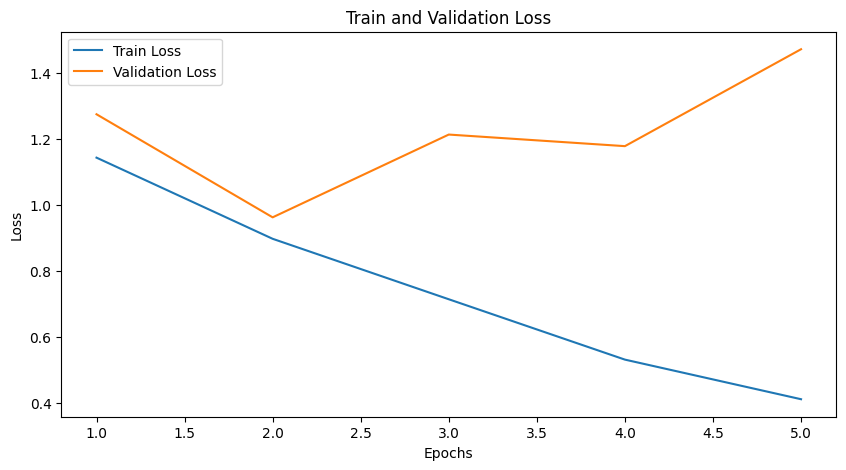

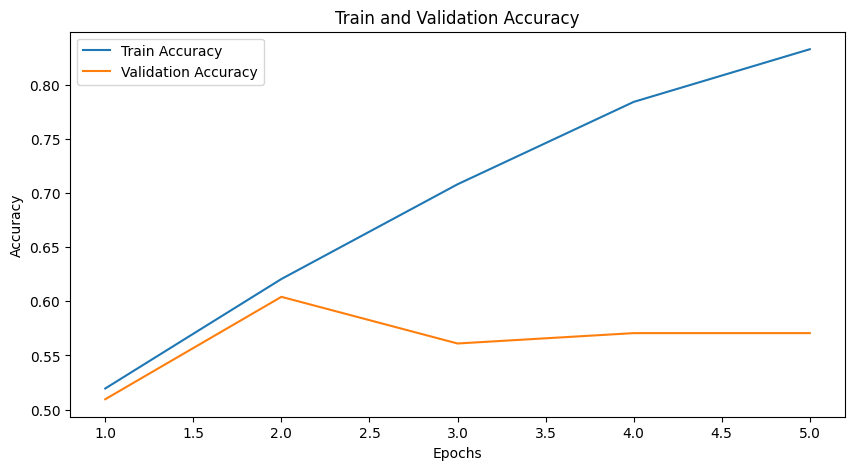

In [ ]:
# Plot training and validation loss over epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_loss_history, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy over epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accuracy_history, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracy_history, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()

# Evaluate Model

In [ ]:
# Evaluate the model on epoch 3 since this performed the best as shown in the graph

# load epoch 3
checkpoint_load = "/content/drive/MyDrive/MyModels/model_checkpoint_epoch_2.pth"
checkpoint = torch.load(checkpoint_load)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=4,
    pin_memory=True if device.type == 'cuda' else False
)


model.eval()

correct = 0
total = 0

# evaluate the model on the subset of the dataset, disable gradient computation, compare these predictions with the labels and count the number of correct predictions
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        predicted = torch.argmax(outputs, dim=1)
        correct += (predicted == labels).sum().item()  # Count correct predictions
        total += labels.size(0)  # compare each element in the batch individually

accuracy = 100 * correct / total
print('Test Accuracy: {:.2f}%'.format(accuracy))

Test Accuracy: 62.38%


In [ ]:
# Function to display a single image with its predicted and true labels
def display_image_with_labels(image, predicted_label, true_label):
    class_names = ['healthy', 'doubtful', 'minimal', 'moderate', 'severe']
    # Convert tensor image to numpy array for visualization
    np_image = image.permute(1, 2, 0).numpy()

    # Display the image
    plt.imshow(np_image)
    plt.axis('off')  # Hide axes

    # Display the predicted label and true label below the image
    plt.title(f'True Label: {class_names[true_label]}\nPredicted Label: {class_names[predicted_label]}', fontsize=12, pad=20)

    # Show the image with labels
    plt.show()




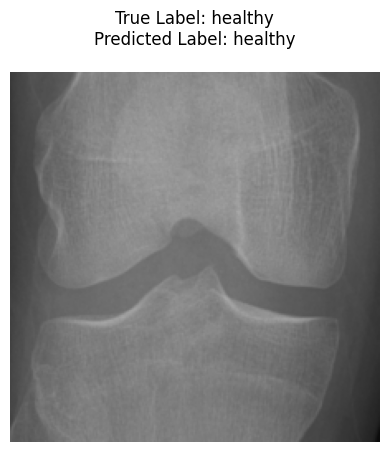

-----------------------------------------------------------------


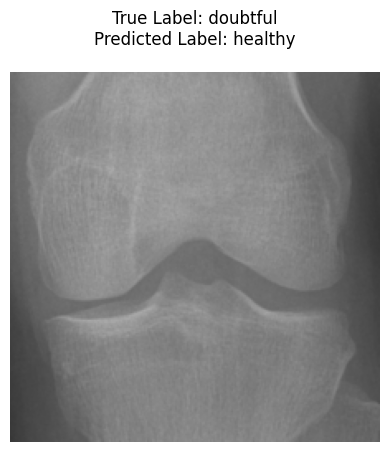

-----------------------------------------------------------------


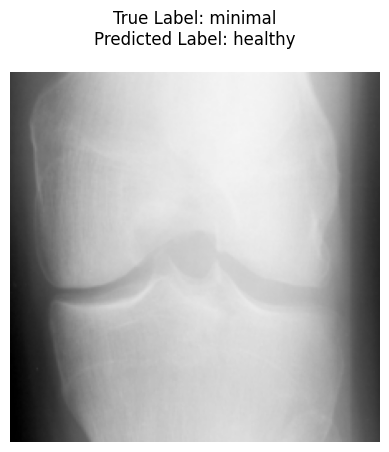

-----------------------------------------------------------------


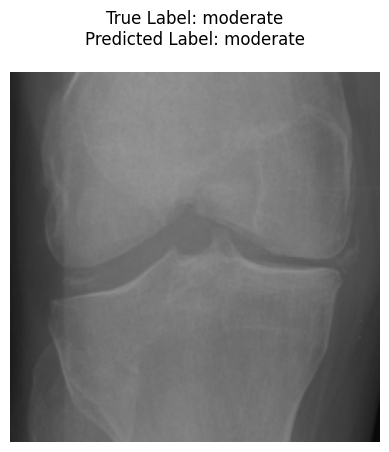

-----------------------------------------------------------------


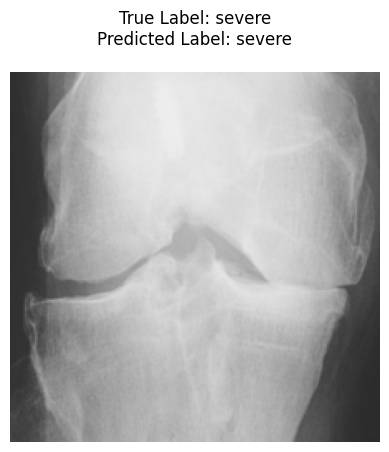

-----------------------------------------------------------------


In [ ]:
# Get a batch of test data

healthy_image, healthy_label = test_dataset[10]
doubtful_image, doubtful_label = test_dataset[800]
minimal_image, minimal_label = test_dataset[1002]
moderate_image, moderate_label = test_dataset[1501]
severe_image, severe_label = test_dataset[685]

# Display the images with their labels
def display_image_with_pred_labels(image, true_label):
    # Convert to numpy for visualization
    np_image = image.permute(1, 2, 0).numpy()  # Ensure correct dimensions

    # Display the image
    plt.imshow(np_image)
    plt.axis('off')  # Hide axes

    # Get model predictions (add batch dimension)
    tensor_image = image.unsqueeze(0)  # Add batch dimension
    output = model(tensor_image)  # Model expects tensor input
    predicted_label = torch.argmax(output, dim=1).item()  # Get the predicted class index

    # Display the image with predicted and true labels
    display_image_with_labels(image, predicted_label, true_label)
    print("-----------------------------------------------------------------")



display_image_with_pred_labels(healthy_image, healthy_label)
display_image_with_pred_labels(doubtful_image, doubtful_label)
display_image_with_pred_labels(minimal_image, minimal_label)
display_image_with_pred_labels(moderate_image, moderate_label)
display_image_with_pred_labels(severe_image, severe_label)



This is a sample of the output of our model when tested. Our model is able to recognize moderatly and severly affected knees very well. However, the model struggles to distinguish between healthy, doubtful, and minimally affected knees. This is likely because there is also some subjectivity in the data because it is labeled by different doctors. Moreover, it is not specified why a knee is labeled a certain way, making it harder for the model to learn the small nuances that differentiate a healthy knee from a doubtful knee for example

# Grad-CAM

In [ ]:
# Function to generate Grad-CAM heatmaps
def generate_gradcam(model, input_tensor, target_class=None):
    # Get the gradient and activation from the last conv layer
    gradients = []
    activations = []

    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0])

    def forward_hook(module, inp, out):
        activations.append(out)

    # Register hooks
    layer = model.layer4
    handle_backward = layer.register_backward_hook(backward_hook)
    handle_forward = layer.register_forward_hook(forward_hook)

    # Forward pass
    model.zero_grad()
    output = model(input_tensor)

    # If no specific target class, pick the class with the maximum score
    if target_class is None:
        target_class = torch.argmax(output)

    # Backward pass for the selected class
    output[:, target_class].backward()

    # Extract gradients and activations
    grad = gradients[0].cpu().data.numpy()[0]
    activation = activations[0].cpu().data.numpy()[0]

    # Compute Grad-CAM
    weights = np.mean(grad, axis=(1, 2))  # global average pooling
    gradcam = np.zeros(activation.shape[1:], dtype=np.float32)

    # Weighted combination of activations
    for i, w in enumerate(weights):
        gradcam += w * activation[i]

    # ReLU to remove negative values
    gradcam = np.maximum(gradcam, 0)

    # Normalize to [0, 1] for visualization
    gradcam = cv2.resize(gradcam, (input_tensor.shape[2], input_tensor.shape[3]))
    gradcam = (gradcam - np.min(gradcam)) / (np.max(gradcam) - np.min(gradcam))

    # Cleanup: remove hooks to avoid memory leaks
    handle_backward.remove()
    handle_forward.remove()

    return gradcam

	 The sample was labeled as Severe


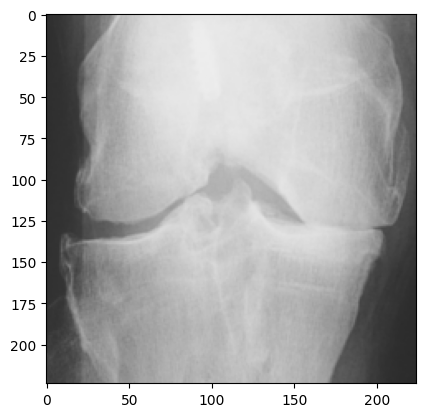

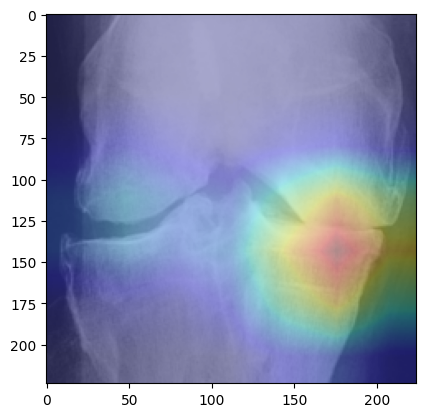

-----------------------------------------------------------------
	 The sample was labeled as Moderate


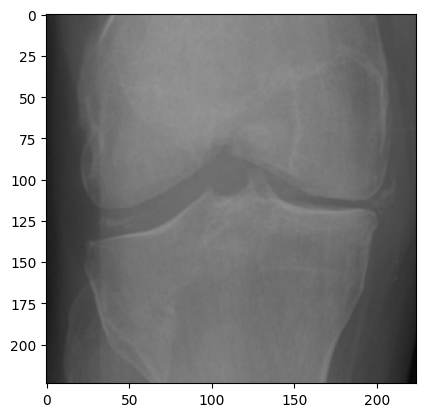

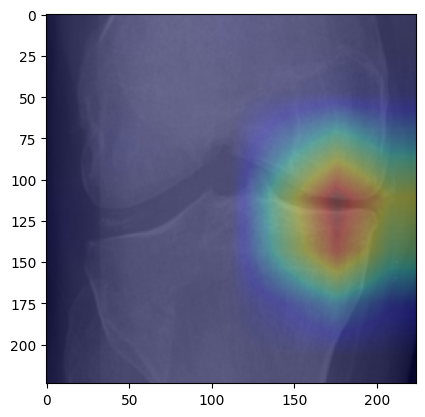

-----------------------------------------------------------------
	 The sample was labeled as Minimal


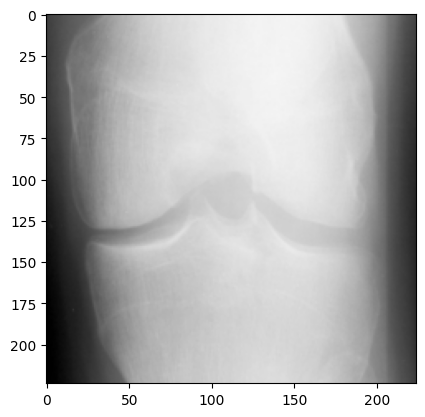

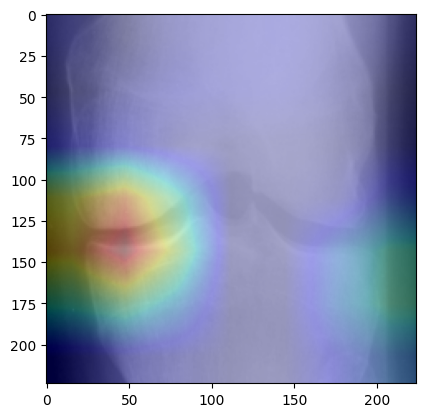

-----------------------------------------------------------------
	 The sample was labeled as Doubtful


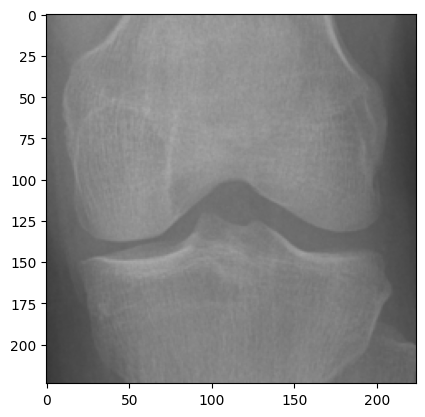

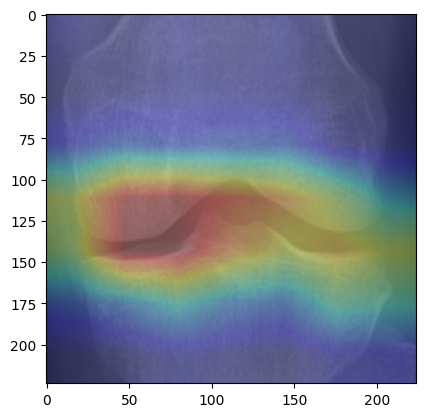

-----------------------------------------------------------------
	 The sample was labeled as Healthy


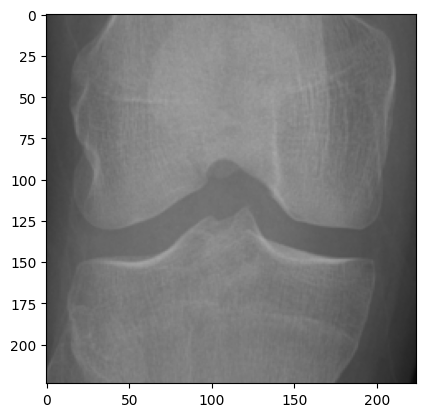

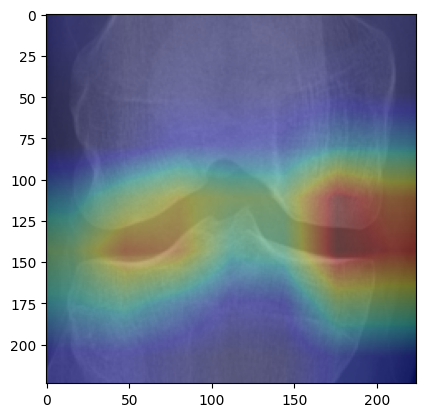

-----------------------------------------------------------------


In [ ]:
# Generate Grad-CAM heatmap example for each class

def visualize_gradcam(model, sample_image, sample_label):
    sample_input = sample_image.unsqueeze(0).to(device)  # Add batch dimension

    gradcam = generate_gradcam(model, sample_input)
    original_image = sample_image.permute(1, 2, 0).cpu().numpy()

    print(f'\t The sample was labeled as {grades[sample_label]}')
    # Visualize the heatmap
    #plt.imshow(gradcam, cmap='jet', alpha=0.7)
    plt.imshow(original_image)
    plt.show()

    # Overlay with original image
    plt.imshow(original_image)  # Original image
    plt.imshow(gradcam, cmap='jet', alpha=0.3)  # Grad-CAM heatmap
    plt.show()

    print("-----------------------------------------------------------------")



model.eval()
healthy_image, healthy_label = test_dataset[10]
doubtful_image, doubtful_label = test_dataset[800]
minimal_image, minimal_label = test_dataset[1002]
moderate_image, moderate_label = test_dataset[1501]
severe_image, severe_label = test_dataset[685]

visualize_gradcam(model, severe_image, severe_label)
visualize_gradcam(model, moderate_image, moderate_label)
visualize_gradcam(model, minimal_image, minimal_label)
visualize_gradcam(model, doubtful_image, doubtful_label)
visualize_gradcam(model, healthy_image, healthy_label)